In [215]:
import torch
import sys
sys.path.append('../')
from DataType.ElectricField import ElectricField
from LightSource.Gaussian_beam import Guassian_beam
from Props.ASM_Prop import ASM_prop
from Props.RSC_Prop import RSC_prop
from Components.Thin_Lens import Thin_LensElement
from Components.Aperture import ApertureElement
from Components.QuantizedDOE import SoftGumbelQuantizedDOELayerv3 as SoftGumbelQuantizedDOELayer
from Components.QuantizedDOE import NaiveGumbelQuantizedDOELayer
from Components.QuantizedDOE import PSQuantizedDOELayer
from Components.QuantizedDOE import STEQuantizedDOELayer
from Components.QuantizedDOE import FullPrecisionDOELayer
from utils.Helper_Functions import normalize
from utils.units import *
import numpy as np
import scipy.io
import time
import torch.nn as nn

In [226]:
# Hologram parameters (high-temp resin)
epsilon = 2.66
tand = 0.03
    
input_field_shape = [100, 100]
input_dxy = 1 * mm
doe_shape = [100, 100]
doe_dxy = 1 * mm
    
    
c0 = 2.998e8
f2 = 220e9  # 0.3 THz
f3 = 330e9  # 0.6 THz
fs = torch.arange(f2, f3, 30e9)

wavelengths = c0 / fs
print("The number of wavelengths: " +  str(wavelengths.shape[0]))

print(fs)

# all parameters of DOE optimization
doe_params = {
    'doe_size': doe_shape,
    'doe_dxy' : doe_dxy,
    'doe_level': 5,
    'look_up_table': None,
    'num_unit': None,
    'height_constraint_max': 1 * mm,
    'tolerance': 0.05 * mm,  
    'material': [epsilon, tand]
}

optim_params = {
    'c_s': 100,
    'tau_max': 5.0,
    'tau_min': 3.0
}

optim_params = {
    'c_s': 150,   # a number to boost the score (higher more robust to gumbel noise)
    'tau_max': 3.5, # maximum value of tau
    'tau_min': 1.5  # minimum value of tau
}

The number of wavelengths: 4
tensor([2.2000e+11, 2.5000e+11, 2.8000e+11, 3.1000e+11])


In [227]:
import numpy as np
from PIL import Image
from utils.Helper_Functions import normalize
import matplotlib.pyplot as plt
import torch.nn.functional as F

def define_FoM(resolution, sampling_size, wavelength, focal_length, position):
    """
    Calculates the Full-width-at-half-maximum (FWHM) by the far-field diffraction limit
    and applies it to model the point spread function (PSF) as a Gaussian function, with consistent intensity across positions.
    
    Parameters:
        resolution (tuple): The resolution of the field in pixels (height, width).
        sampling_size (float): The physical size of each pixel, in meters.
        wavelength (float): The wavelength of the light, in meters.
        focal_length (float): The focal length of the optical system, in meters.
        position (tuple): The target position in the field, in meters (x, y).
        
    Returns:
        torch.Tensor: The calculated and normalized PSF as a 2D Gaussian function over the specified field.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    height, width = resolution
    Length_x = sampling_size * width
    Length_y = sampling_size * height
    
    effective_L = torch.sqrt(torch.tensor((Length_x ** 2 + Length_y ** 2), device=device))
    NA = torch.sin(torch.atan(effective_L / (2 * focal_length)))
    FWHM = wavelength / (2 * NA)
    
    x_grid, y_grid = torch.meshgrid(torch.linspace(-Length_x / 2, Length_x / 2, steps=width, device=device),
                                    torch.linspace(-Length_y / 2, Length_y / 2, steps=height, device=device))
    
    x_position, y_position = torch.tensor(position, device=device)
    
    # Calculate the Gaussian PSF
    PSF = torch.exp(-((x_grid - x_position) ** 2 + (y_grid - y_position) ** 2) / ((FWHM*2) ** 2))
    
    # Normalize the PSF such that its maximum value is 1
    
    return normalize(PSF.unsqueeze(0).unsqueeze(0))

In [228]:
PSF_1 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths[0], focal_length=100*mm, position=[0*mm, -30*mm])

PSF_2 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths[0], focal_length=100*mm, position=[0*mm, 30*mm])

PSF_3 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths[0], focal_length=100*mm, position=[0*mm, -10*mm])

PSF_4 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths[0], focal_length=100*mm, position=[0*mm, 10*mm])

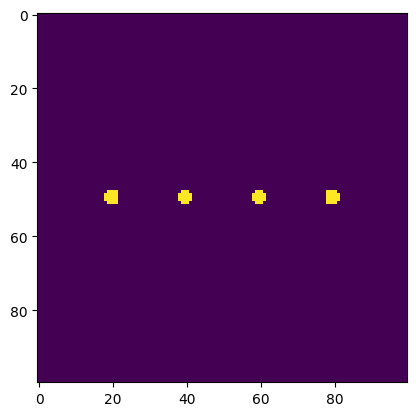

In [229]:
target = torch.concat([PSF_1, PSF_2, PSF_3, PSF_4], 1)
target.shape

target_vis = torch.round(PSF_1 + PSF_2 + PSF_3 + PSF_4)
plt.imshow(target_vis[0, 0, :, :].cpu())

In [236]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = SoftGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        
        self.asm_prop3 = ASM_prop(z_distance=100 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [237]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.16113535] m, the TF will be fine during the sampling !
The critical distance is [0.16113535] m, the TF will be fine during the sampling !


In [238]:
max_itrs = 10000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target = target.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 1000 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss and itr > max_itrs * 0.8:
        best_loss = loss
        best_field = out_field

The critical distance is [0.16113535] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.012155958451330662
The iteration : 1000, Loss: 0.0008660030434839427
The iteration : 2000, Loss: 0.0006713056354783475
The iteration : 3000, Loss: 0.0005646717036142945
The iteration : 4000, Loss: 0.0005174596444703639
The iteration : 5000, Loss: 0.0004596769285853952
The iteration : 6000, Loss: 0.0004326558846514672
The iteration : 7000, Loss: 0.00041601722477935255
The iteration : 8000, Loss: 0.0004113990580663085
The iteration : 9000, Loss: 0.00042122439481317997
The iteration : 9999, Loss: 0.0004191282787360251


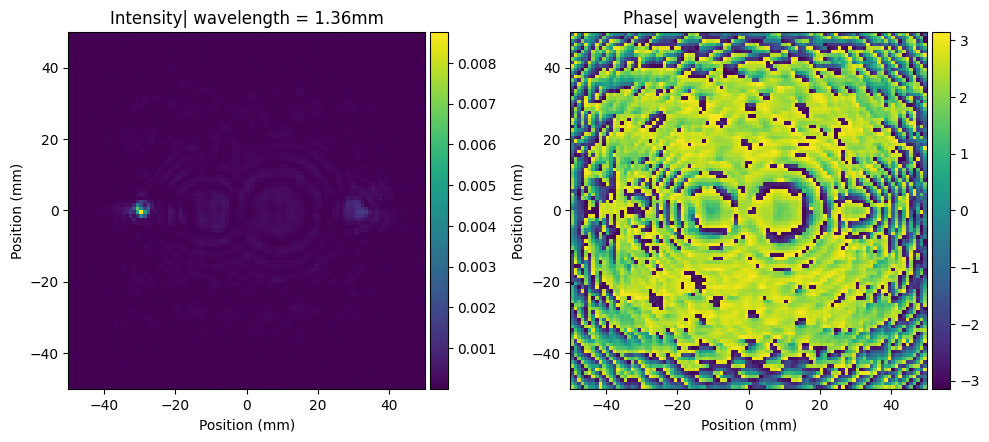

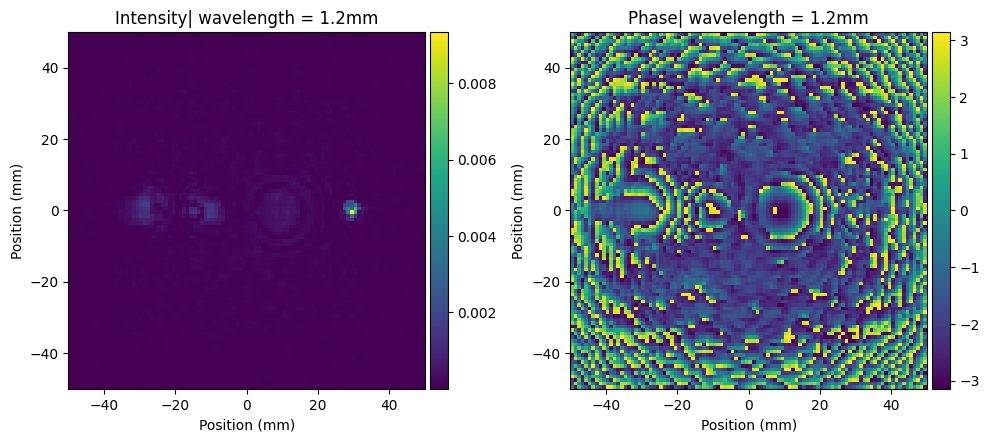

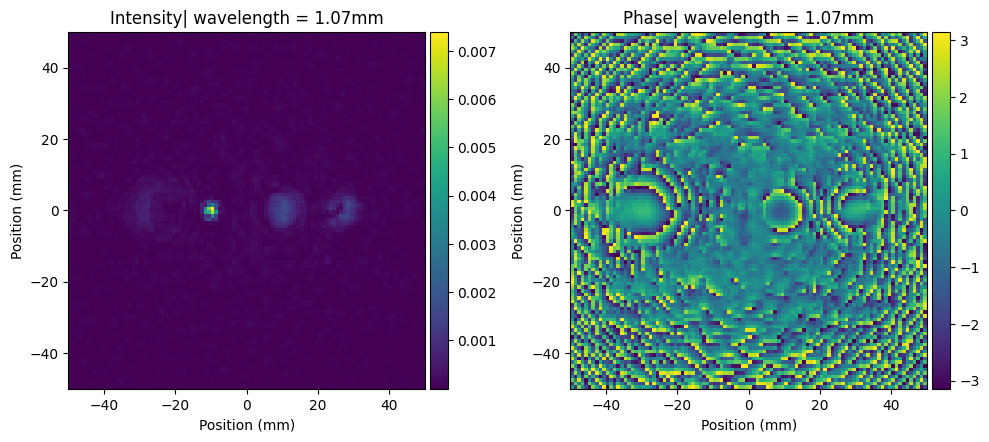

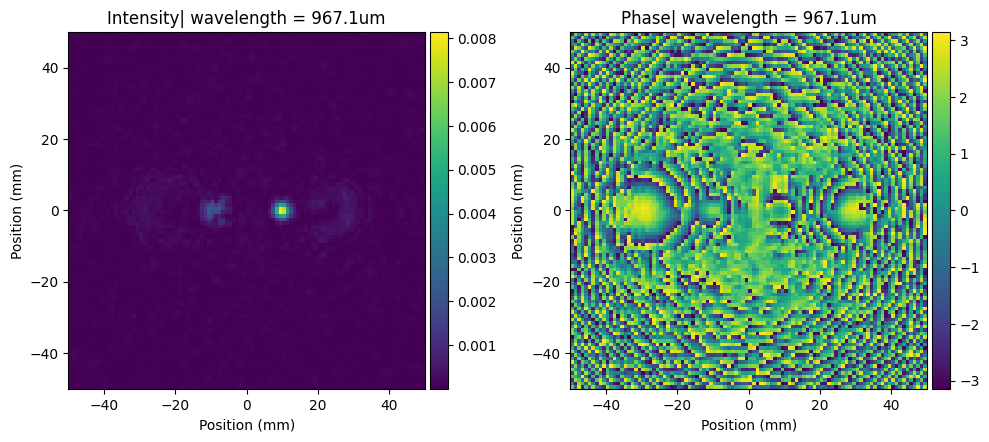

In [239]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[0], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[1], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[2], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[3], intensity=True)
#best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[4], intensity=True)

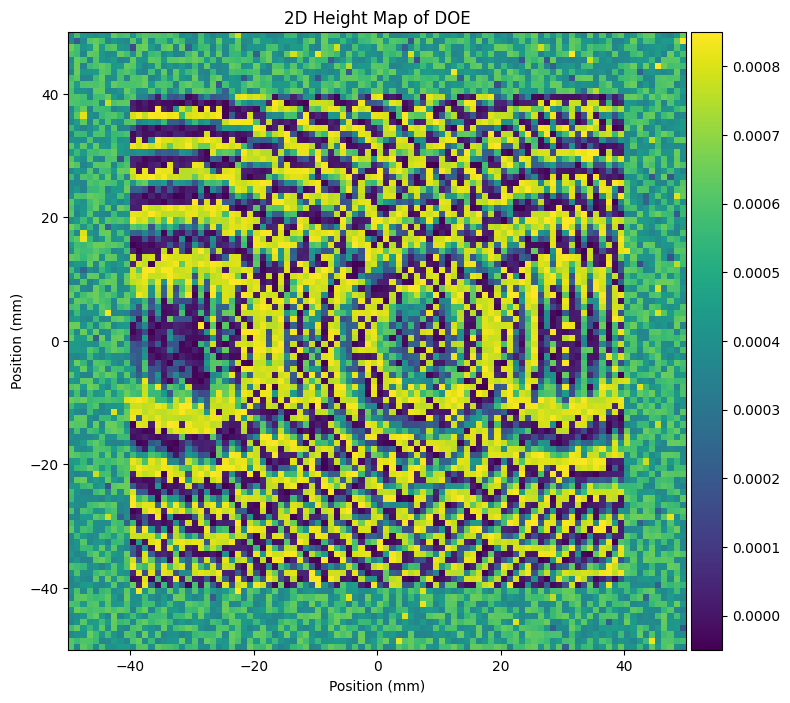

In [240]:
setup.doe.visualize(figsize=(8,8))

In [241]:
setup.doe.height_map.unique() / mm

tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000], device='cuda:0',
       grad_fn=<DivBackward0>)

# Define the System with FullPrecisionDOE

In [242]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=4, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = FullPrecisionDOELayer(self.doe_params)
        
        self.asm_prop3 = ASM_prop(z_distance=100 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [243]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26855892] m, the TF will be fine during the sampling !
The critical distance is [0.26855892] m, the TF will be fine during the sampling !


In [244]:
max_itrs = 10000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target = target.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 1000 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field = out_field

The critical distance is [0.26855892] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.012848608195781708
The iteration : 1000, Loss: 0.0009522571344859898
The iteration : 2000, Loss: 0.0006914960686117411
The iteration : 3000, Loss: 0.0005773846060037613
The iteration : 4000, Loss: 0.0005210470408201218
The iteration : 5000, Loss: 0.0004786117060575634
The iteration : 6000, Loss: 0.0004480732895899564
The iteration : 7000, Loss: 0.0004286457842681557
The iteration : 8000, Loss: 0.00037793171941302717
The iteration : 9000, Loss: 0.00036542012821882963
The iteration : 9999, Loss: 0.0003586792736314237


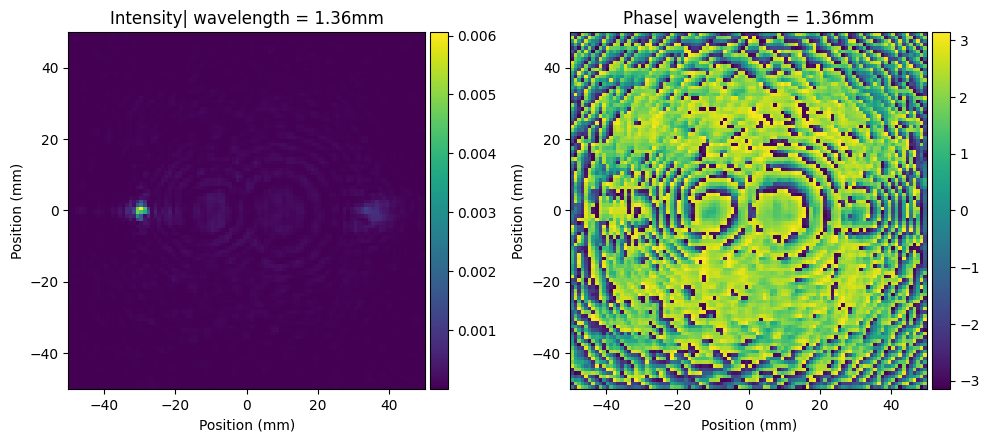

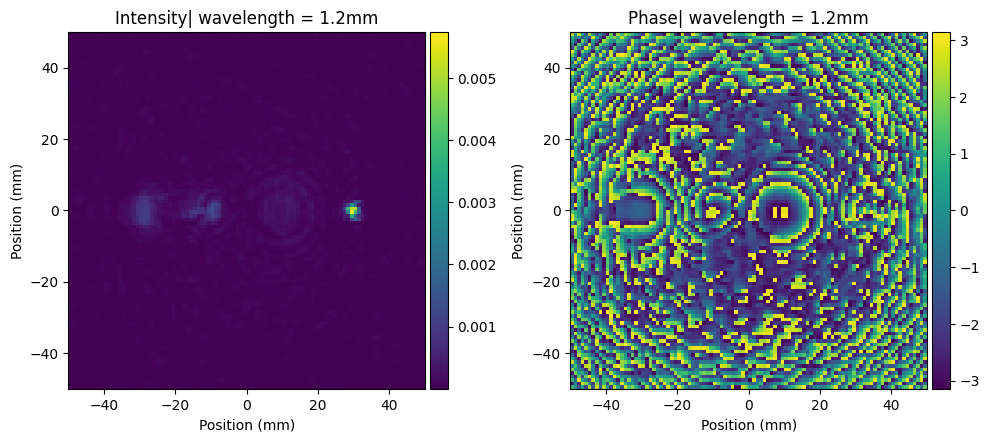

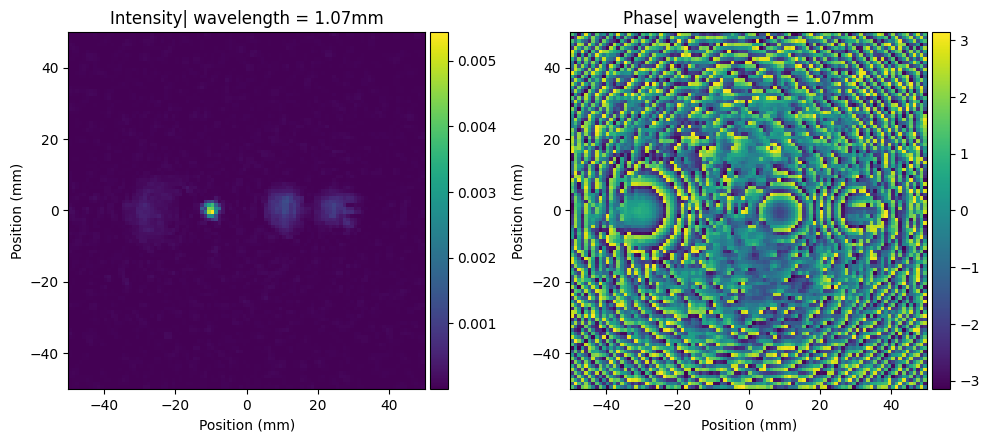

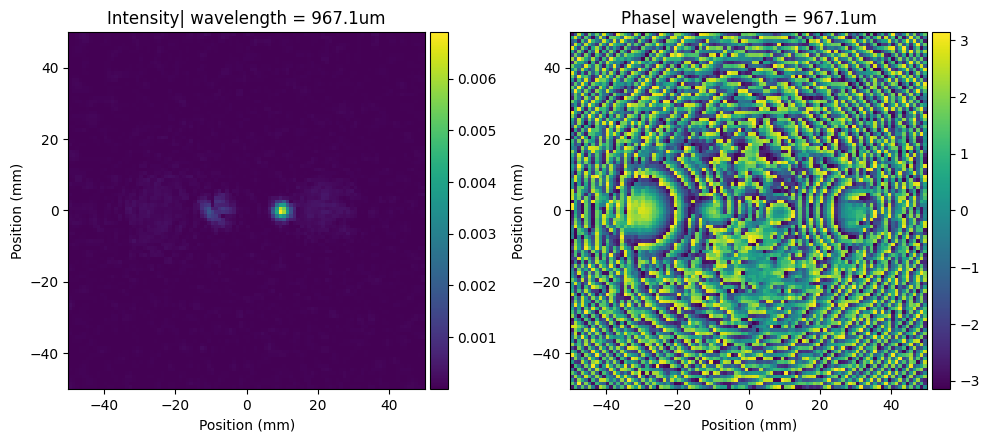

In [245]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[0], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[1], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[2], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[3], intensity=True)
#best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[4], intensity=True)

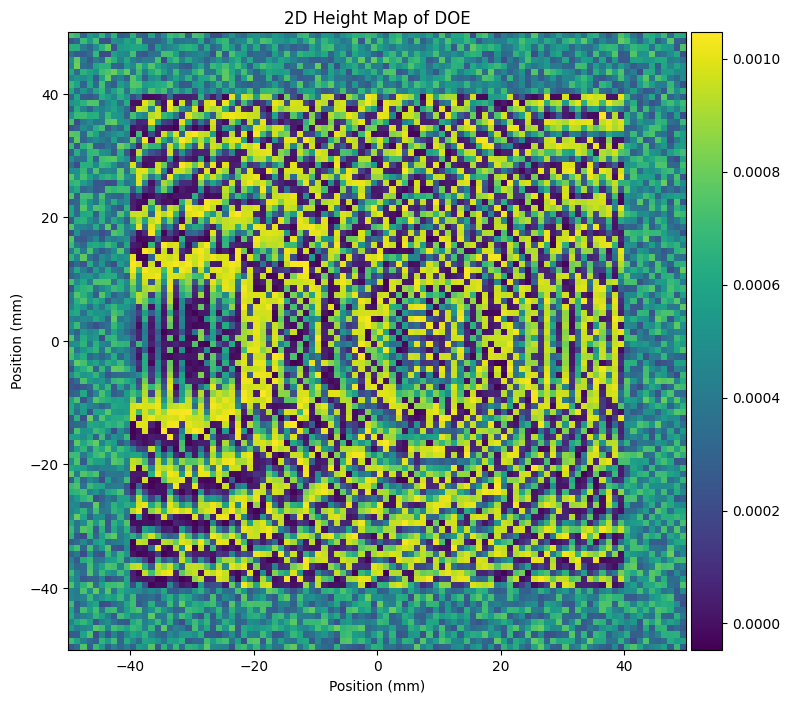

In [246]:
setup.doe.visualize(figsize=(8,8))

# 3. System with NaiveGumbelQuantizedDOELayer

In [247]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=4, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = NaiveGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        
        self.asm_prop3 = ASM_prop(z_distance=100 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [249]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

max_itrs = 10000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target = target.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 1000 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field = out_field


The critical distance is [0.26855892] m, the TF will be fine during the sampling !
The critical distance is [0.26855892] m, the TF will be fine during the sampling !
The critical distance is [0.26855892] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.004791570361703634
The iteration : 1000, Loss: 0.0010126989800482988
The iteration : 2000, Loss: 0.0009662648080848157
The iteration : 3000, Loss: 0.0009284077677875757
The iteration : 4000, Loss: 0.0009070373489521444
The iteration : 5000, Loss: 0.0008837237255647779
The iteration : 6000, Loss: 0.000811185163911432
The iteration : 7000, Loss: 0.0006942075560800731
The iteration : 8000, Loss: 0.0005963692674413323
The iteration : 9000, Loss: 0.0005286307423375547
The iteration : 9999, Loss: 0.0004932311130687594


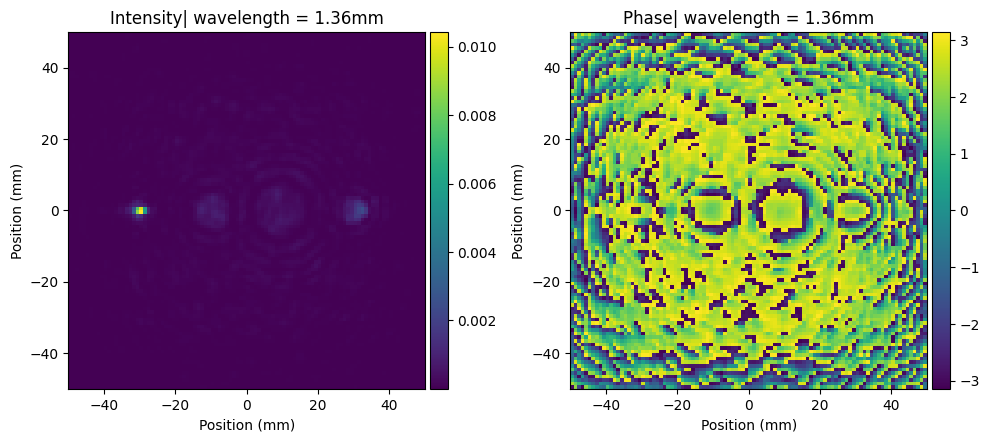

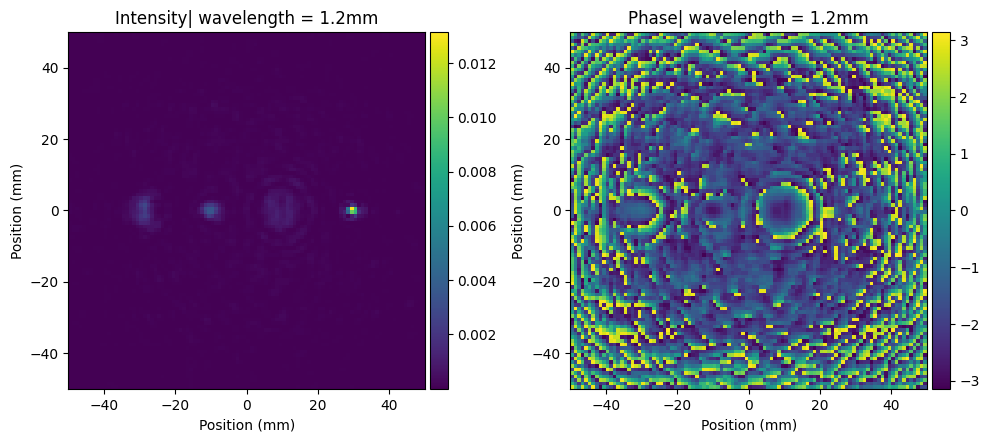

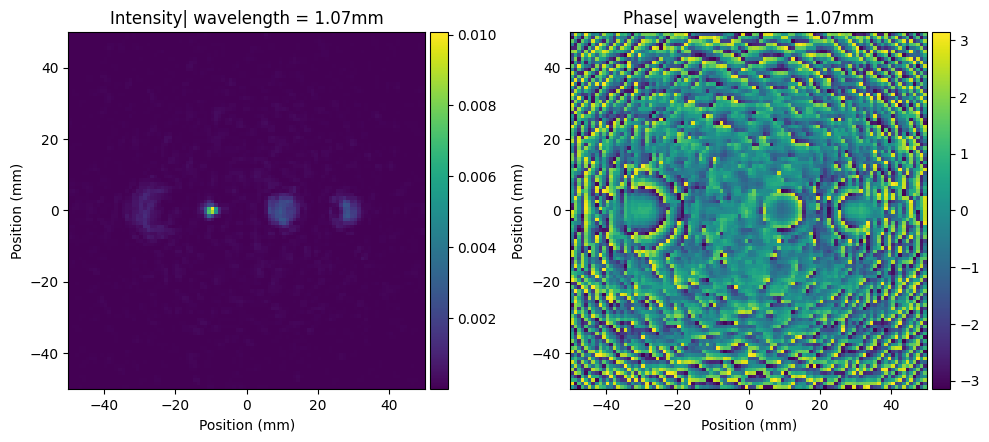

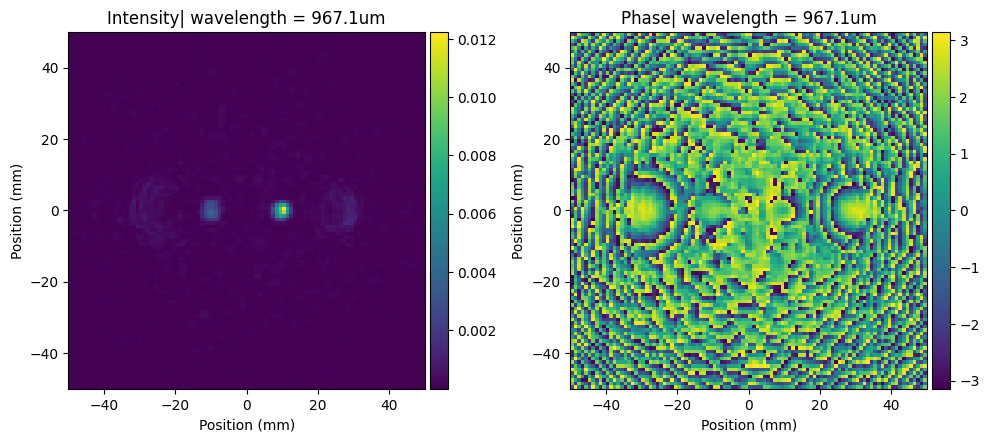

In [250]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[0], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[1], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[2], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[3], intensity=True)
#best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[4], intensity=True)

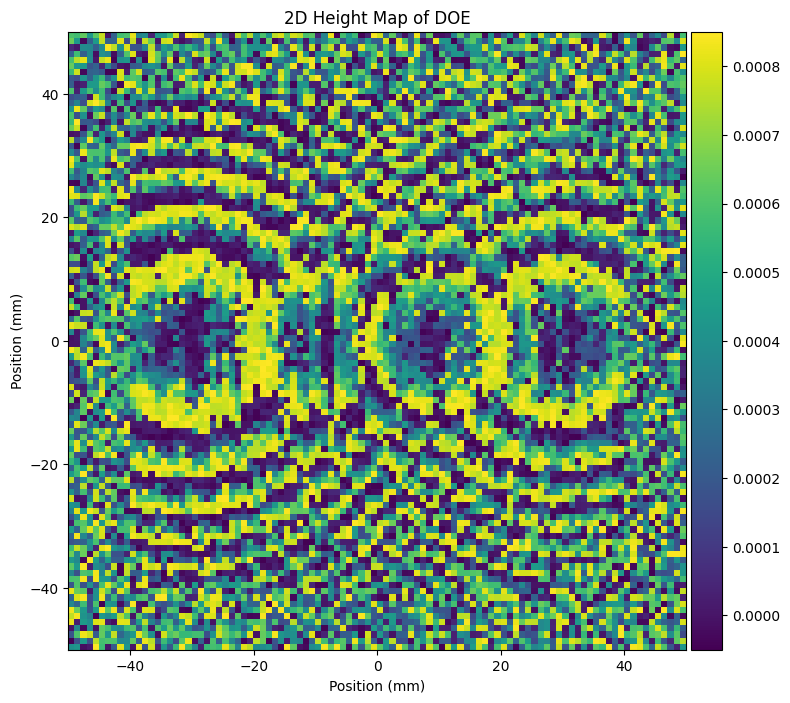

In [251]:
setup.doe.visualize(figsize=(8,8))

# System with PSQuantizedDOELayer

In [252]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=4, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = PSQuantizedDOELayer(self.doe_params, self.optim_params)
        
        self.asm_prop3 = ASM_prop(z_distance=100 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [253]:
optim_params = {
    'c_s': 300,
    'tau_max': 800,
    'tau_min': 1
}
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

max_itrs = 10000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target = target.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 1000 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field = out_field

The critical distance is [0.26855892] m, the TF will be fine during the sampling !
The critical distance is [0.26855892] m, the TF will be fine during the sampling !
The critical distance is [0.26855892] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.02618448995053768
The iteration : 1000, Loss: 0.0009862590814009309
The iteration : 2000, Loss: 0.0009850756032392383
The iteration : 3000, Loss: 0.0009786044247448444
The iteration : 4000, Loss: 0.0009698722860775888
The iteration : 5000, Loss: 0.0009630302083678544
The iteration : 6000, Loss: 0.000944868428632617
The iteration : 7000, Loss: 0.0009378535905852914
The iteration : 8000, Loss: 0.0009207703405991197
The iteration : 9000, Loss: 0.0009126267395913601
The iteration : 9999, Loss: 0.0009041018201969564


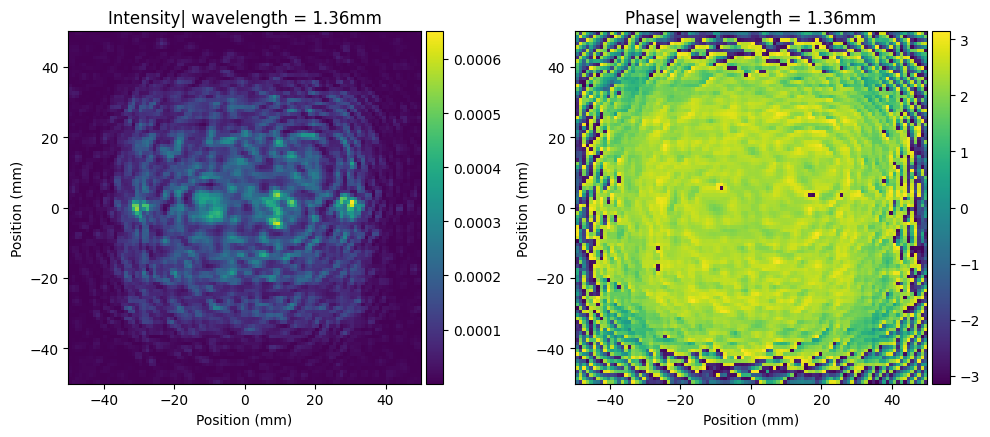

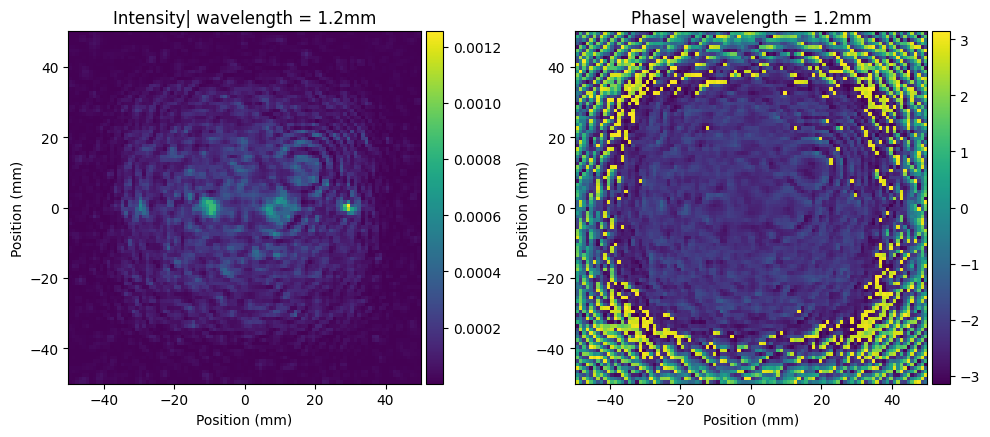

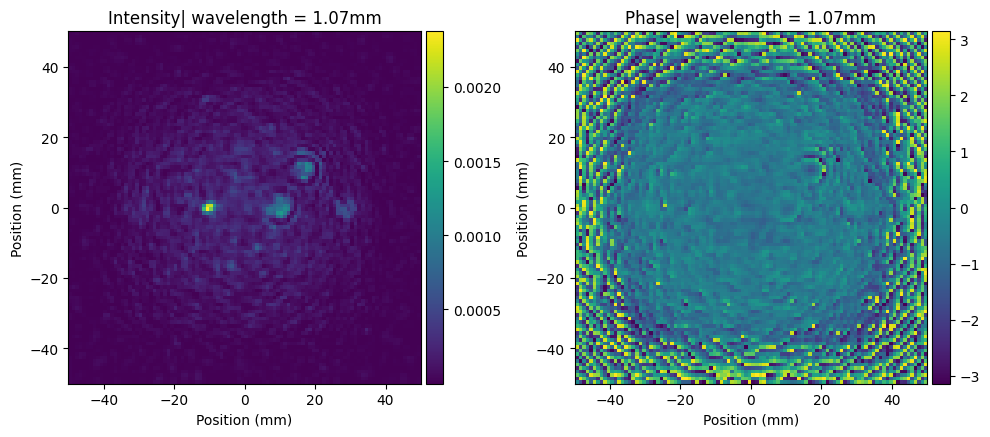

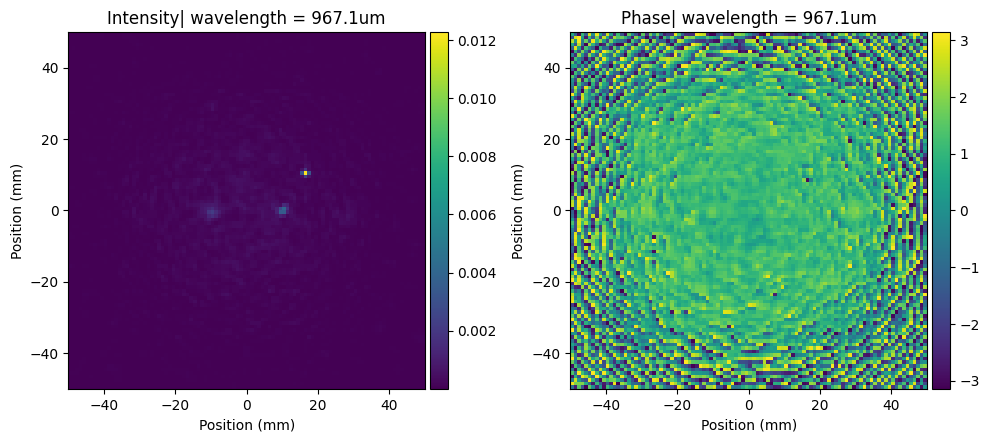

In [254]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[0], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[1], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[2], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[3], intensity=True)
#best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[4], intensity=True)

# 6. System with STEQuantizedDOELayer

In [255]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=4, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = STEQuantizedDOELayer(self.doe_params, self.optim_params)
        
        self.asm_prop3 = ASM_prop(z_distance=100 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=4, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [256]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

max_itrs = 10000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target = target.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 1000 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field = out_field

The critical distance is [0.26855892] m, the TF will be fine during the sampling !
The critical distance is [0.26855892] m, the TF will be fine during the sampling !
The critical distance is [0.26855892] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.014850136823952198
The iteration : 1000, Loss: 0.0009509803494438529
The iteration : 2000, Loss: 0.0007682070136070251
The iteration : 3000, Loss: 0.000656920310575515
The iteration : 4000, Loss: 0.000586674315854907
The iteration : 5000, Loss: 0.0005122485454194248
The iteration : 6000, Loss: 0.0004789664235431701
The iteration : 7000, Loss: 0.0004551046877168119
The iteration : 8000, Loss: 0.0004318448482081294
The iteration : 9000, Loss: 0.0004231138154864311
The iteration : 9999, Loss: 0.0004177430528216064


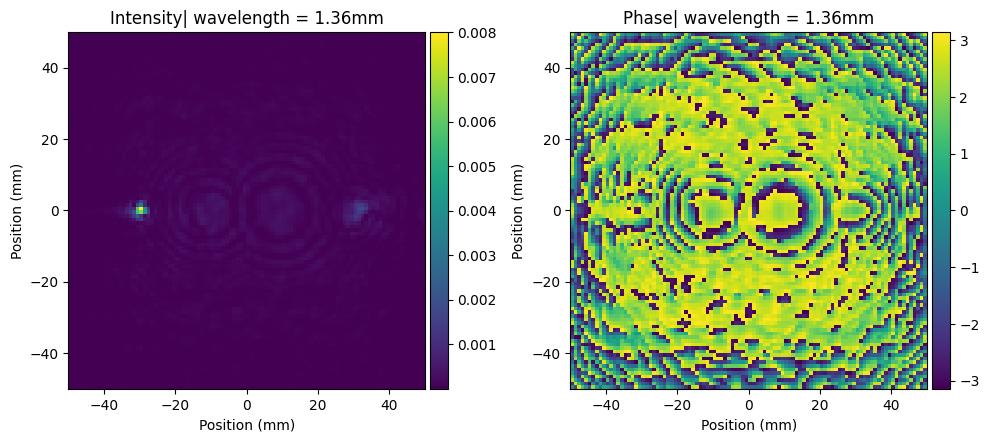

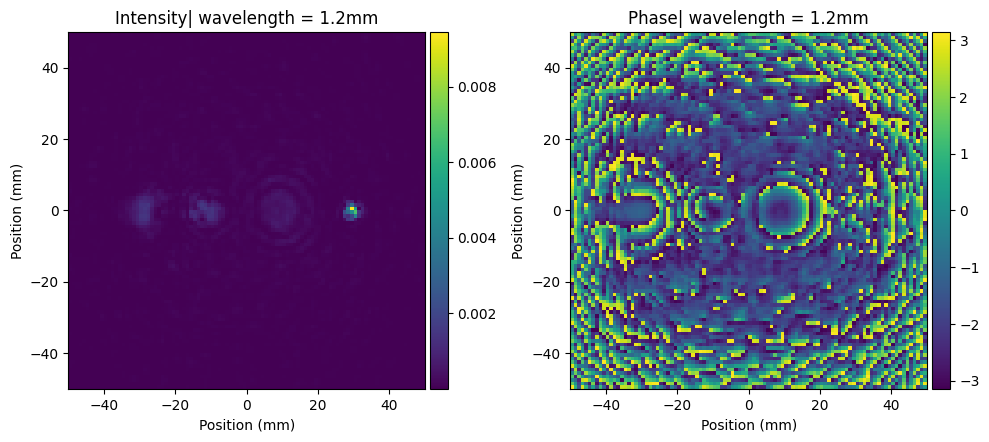

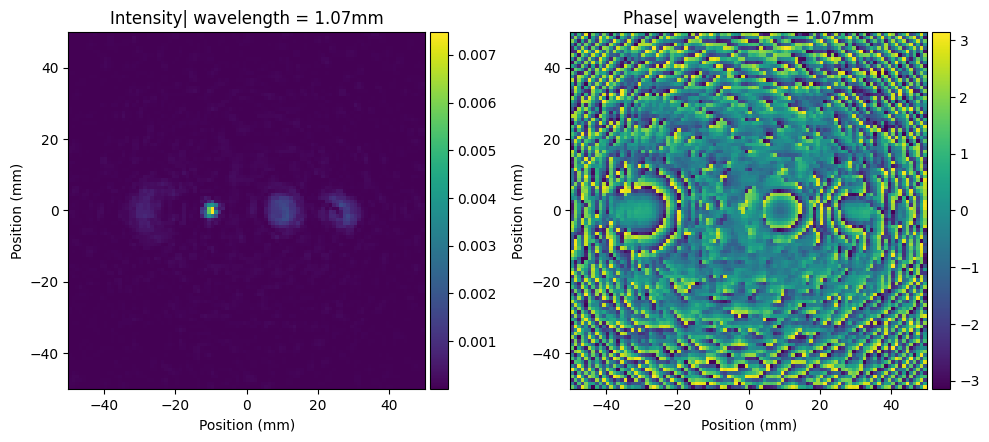

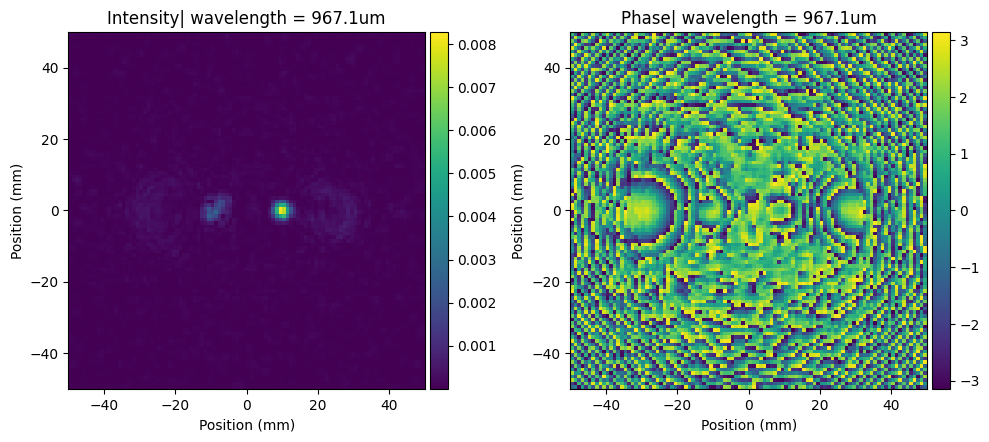

In [257]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[0], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[1], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[2], intensity=True)
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[3], intensity=True)
#best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths[4], intensity=True)

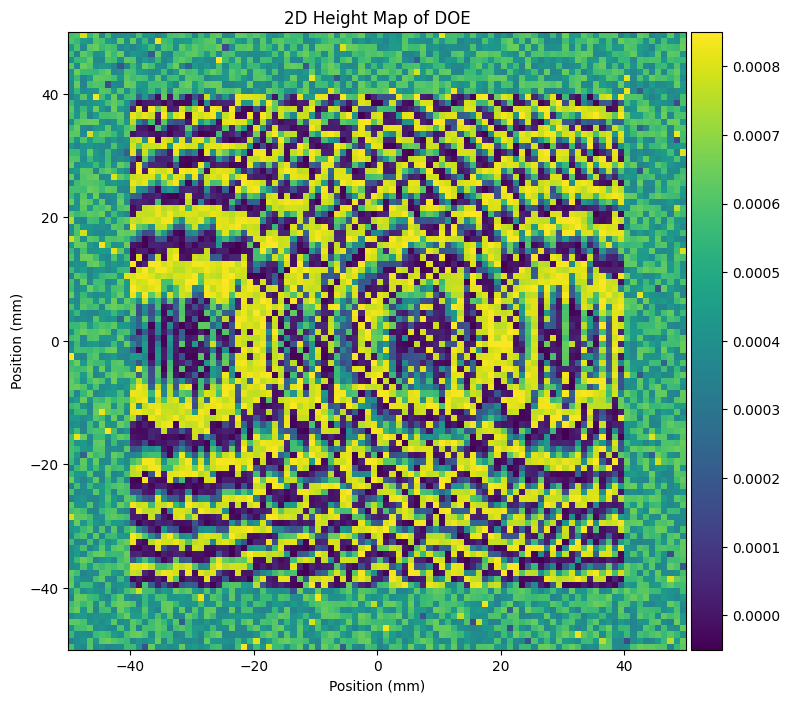

In [258]:
setup.doe.visualize(figsize=(8,8))

## 1. Visualize for 1D distribution

In [119]:
#out_amp = normalize(torch.abs(out_field.data)**2)

IndexError: index 149 is out of bounds for dimension 2 with size 100

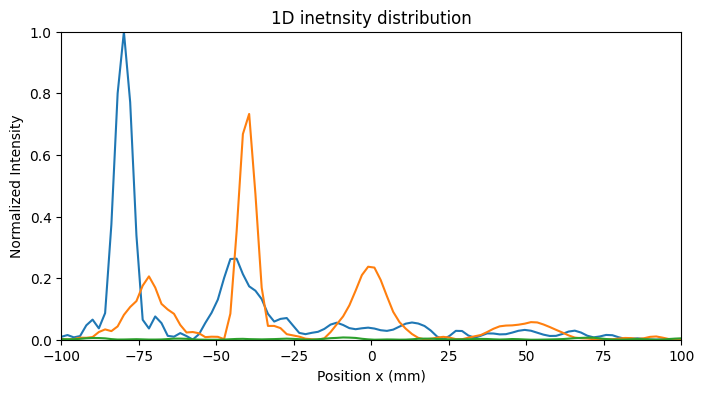

In [120]:
# 1D distribution for spot 1 and 2
from utils.Visualization_Helper import float_to_unit_identifier, add_colorbar

size_x = np.array(1 * mm * 200 / 2)
unit_val, unit_axis = float_to_unit_identifier(size_x)
size_x = size_x / unit_val

plt.figure(figsize=(8, 4))
plt.subplot(1, 1, 1)
x_axis_spot_300GHz = out_amp[0, 0, 49, :]
x_axis_spot_300GHz = x_axis_spot_300GHz.cpu().detach().numpy()
new_x_axis = np.linspace(-size_x, size_x, len(x_axis_spot_300GHz))
plt.plot(new_x_axis, x_axis_spot_300GHz, label="0.3THz (y=50 mm)")
plt.ylim([0,1])
plt.xlim([-size_x, size_x])
plt.xlabel("Position x (" + unit_axis + ")")
plt.ylabel("Normalized Intensity")
plt.title("1D inetnsity distribution")

x_axis_spot_400GHz = out_amp[0, 1, 49, :]
x_axis_spot_400GHz = x_axis_spot_400GHz.cpu().detach().numpy()
plt.plot(new_x_axis, x_axis_spot_400GHz, label="0.4THz (y=50 mm)")

x_axis_spot_500GHz = out_amp[0, 2, 99, :]
x_axis_spot_500GHz = x_axis_spot_500GHz.cpu().detach().numpy()
plt.plot(new_x_axis, x_axis_spot_500GHz, label="0.5THz (y=0 mm)")

x_axis_spot_600GHz = out_amp[0, 3, 149, :]
x_axis_spot_600GHz = x_axis_spot_600GHz.cpu().detach().numpy()
plt.plot(new_x_axis, x_axis_spot_600GHz, label="0.6THz (y=-50 mm)")

x_axis_spot_700GHz = out_amp[0, 4, 149, :]
x_axis_spot_700GHz = x_axis_spot_700GHz.cpu().detach().numpy()
plt.plot(new_x_axis, x_axis_spot_700GHz, label="0.7THz (y=-50 mm)")

plt.legend(loc="upper left")

plt.tight_layout()

## 2. Visualize for 2D quantized phase map of DOE